Demo File for Speech Recognition and Speech Synthesis use Cases 

In [1]:
# Requirements
!pip -q install -U openai-whisper
!pip -q install wavio
!pip -q install scipy
!pip -q install sounddevice
#!pip3 -q install pyaudio
# Might need to conda install ffmpeg

Introducing Whisper for non-real time transcriptions

/opt/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 This is a test recording.
Detected language: en
This is a test recording.


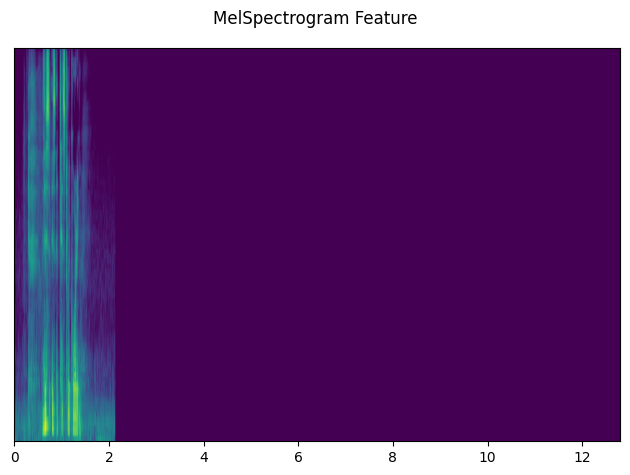

In [40]:
import whisper
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv

def _plot(feats, num_iter, unit=25):
    unit_dur = segment_length / sample_rate * unit
    fig, ax = plt.subplots(1, 1)
    t0 = 0
    
    t1 = t0 + segment_length / sample_rate * len(feats)
    
    ax.imshow(feats, extent=[t0, t1, 0, 1], aspect="auto", origin="lower")
    ax.tick_params(which="both", left=False, labelleft=False)
    ax.set_xlim(t0, t1)
    t0 = t1
    fig.suptitle("MelSpectrogram Feature")
    plt.tight_layout()

# Hi this is a sample recording of my voice and to see how well the speech recognition is working.

# Sampling frequency
freq = 16000
 
# Recording duration
duration = 5
 
# Start recorder with the given values 
# of duration and sample frequency
#recording = sd.rec(int(duration * freq), 
                   #samplerate=freq, channels=1)

#print('Recording Audio...') 
# Record audio for the given number of seconds
#sd.wait()
 
# This will convert the NumPy array to an audio
# file with the given sampling frequency
#write("recording0.wav", freq, recording)

# Use internal transcription definition (Quick Way)
model = whisper.load_model("base")
result = model.transcribe("recording0.wav")
print(result["text"])


# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("recording0.wav")

audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

_plot(mel, mel.size(dim=0))

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(
    task = "transcribe",

    # language that the audio is in; uses detected language if None
    language= max(probs, key=probs.get),

    # sampling-related options
    temperature = 0.0,
    sample_len = None,  # maximum number of tokens to sample
    best_of = None,  # number of independent sample trajectories, if t > 0
    beam_size = None,  # number of beams in beam search, if t == 0
    patience = None,  # patience in beam search (arxiv:2204.05424)

    # text or tokens to feed as the prompt or the prefix; for more info:
    # https://github.com/openai/whisper/discussions/117#discussioncomment-3727051
    prompt = None,  # for the previous context
    prefix = None,  # to prefix the current context

    # list of tokens ids (or comma-separated token ids) to suppress
    # "-1" will suppress a set of symbols as defined in `tokenizer.non_speech_tokens()`
    suppress_tokens = "-1",
    suppress_blank = True,  # this will suppress blank outputs

    # timestamp sampling options
    without_timestamps = False,  # use <|notimestamps|> to sample text tokens only
    max_initial_timestamp = 1.0,

    # implementation details
    fp16 = False,  # use fp16 for most of the calculation
)
                                  
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Introducing Emformer for real-time transcriptions

In [7]:
#Requirements 
!pip install torch
!pip install torchaudio
!pip install SentencePiece

# Might need to conda install ffmpeg

In [9]:
import torch
import torchaudio 

class ContextCacher:
    """Cache the end of input data and prepend the next input data with it.

    Args:
        segment_length (int): The size of main segment.
            If the incoming segment is shorter, then the segment is padded.
        context_length (int): The size of the context, cached and appended.
    """

    def __init__(self, segment_length: int, context_length: int):
        self.segment_length = segment_length
        self.context_length = context_length
        self.context = torch.zeros([context_length])

    def __call__(self, chunk: torch.Tensor):
        if chunk.size(0) < self.segment_length:
            chunk = torch.nn.functional.pad(chunk, (0, self.segment_length - chunk.size(0)))
        chunk_with_context = torch.cat((self.context, chunk))
        self.context = chunk[-self.context_length :]
        return chunk_with_context
    

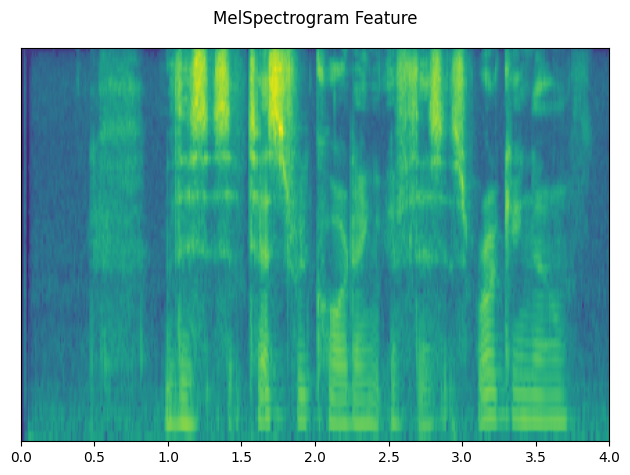

In [27]:
from torchaudio.io import StreamReader

def _plot(feats, num_iter, unit=25):
    unit_dur = segment_length / sample_rate * unit
    fig, ax = plt.subplots(1, 1)
    t0 = 0
    
    t1 = t0 + segment_length / sample_rate * len(feats)
    feats = torch.cat([f[2:-2] for f in feats])  # remove boundary effect and overlap
    ax.imshow(feats.T, extent=[t0, t1, 0, 1], aspect="auto", origin="lower")
    ax.tick_params(which="both", left=False, labelleft=False)
    ax.set_xlim(t0, t0 + unit_dur)
    t0 = t1
    fig.suptitle("MelSpectrogram Feature")
    plt.tight_layout()

src = "recording0.wav"

# Get pipeline
bundle = torchaudio.pipelines.EMFORMER_RNNT_BASE_LIBRISPEECH

feature_extractor = bundle.get_streaming_feature_extractor()
decoder = bundle.get_decoder()
token_processor = bundle.get_token_processor()

sample_rate = bundle.sample_rate
segment_length = bundle.segment_length * bundle.hop_length
context_length = bundle.right_context_length * bundle.hop_length

# Stream Audio File
streamer = StreamReader(src)
streamer.add_basic_audio_stream(frames_per_chunk=segment_length, sample_rate=bundle.sample_rate)

state, hypothesis = None, None    
cacher = ContextCacher(segment_length, context_length)

stream_iterator = streamer.stream()

# Run speech recognition
@torch.inference_mode()
def run_inference(num_iter=1000):
    global state, hypothesis
    chunks = []
    feats = []
    for i, (chunk,) in enumerate(stream_iterator, start=1):
        segment = cacher(chunk[:, 0])
        features, length = feature_extractor(segment)
        hypos, state = decoder.infer(features, length, 10, state=state, hypothesis=hypothesis)
        hypothesis = hypos
        transcript = token_processor(hypos[0][0], lstrip=False)
        print(transcript, end="\r", flush=True)

        feats.append(features)
        if i == num_iter:
            break

    _plot(feats, num_iter)

run_inference()



Speech Synthesis Tacotron2 and HifiGan 

More Links to check out:
https://google.github.io/tacotron/publications/tacotron2/index.html
https://github.com/suno-ai/bark
https://github.com/coqui-ai/TTS

Speech Brain
https://github.com/speechbrain/speechbrain/

In [13]:
!pip3 -q install deep_phonemizer
!pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.3/263.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 25.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.0 MB/s eta 0:00:00


In [14]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt

[31, 19, 20, 30, 11, 20, 30, 11, 12, 11, 29, 16, 30, 27, 26, 25, 30, 16, 11, 31, 16, 35, 31, 7]


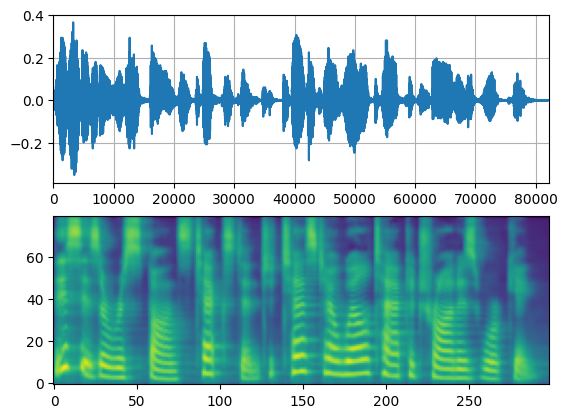

In [18]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

torch.random.manual_seed(0)

symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

text = "This is a response text."
print(text_to_sequence(text))

with torch.inference_mode():
    processed, lengths = processor(text)
    print([processor.tokens[i] for i in processed[0, : lengths[0]]])
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

plot(waveforms, spec, 22050)